# Introduction

This notebook aims to predict the severity level for the UK car accidents dataset. The notebook is divided into 7 sections. We will first gain some basic understanding about the dataset. Then, we will transform the existing features or derive additional features that will help in prediction. After we have generated all features, it is essential to select the appropriate features and have suitable training set data. With our data ready, we will then move on to train our model with the appropriate model selected, optimal number of features and hyperparameter values. At last, we will be able to build a high performing final model.

<div class="alert alert-block alert-info">
<h3> Content </h3>
<br>
&nbsp;&nbsp; 1. Data Overview
<br>
&nbsp;&nbsp; 2. Feature Engineering
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.1 Transforming Geographical Data
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.2 Adding Additional Time Features
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.3 Transform to Numeric Categorical Values
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.4 Adjusting the Scale for Speed Limit
<br>
&nbsp;&nbsp; 3. Feature Selection
<br>
&nbsp;&nbsp; 4. Sampling the Dataset
<br>
&nbsp;&nbsp; 5. One Hot Encoding
<br>
&nbsp;&nbsp; 6. Prediction Model Training
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 6.1 Model Selection
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 6.2 Dimensionality Reduction - PCA
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 6.3 Recursive Feature Elimination
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 6.4 Hyperparameters Tuning
<br>
&nbsp;&nbsp; 7. Final Model
<br>
</div>

# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
from matplotlib import colors as mcolors
from sklearn.cluster import KMeans
import seaborn as sns
sns.set(style="white")
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import seaborn as sns
sns.set(style="white")
from scipy.stats import norm
from scipy import stats
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

# packages for prediction
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

# 1. Dataset Overview

In [2]:
# reading files
solution = pd.read_csv("solutions_sample.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
ukTraffic = pd.read_csv("ukTrafficAADF.csv")

/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print ("Length of the training dataset is:", len(train))
print ("Length of the testing dataset is:", len(test))

Length of the training dataset is: 1196390
Length of the testing dataset is: 513643


In [4]:
# getting to know the variables in the training dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1196390 entries, 0 to 1196389
Data columns (total 33 columns):
Accident_Index                                 1196390 non-null object
Location_Easting_OSGR                          1196175 non-null float64
Location_Northing_OSGR                         1196175 non-null float64
Longitude                                      1196175 non-null float64
Latitude                                       1196175 non-null float64
Police_Force                                   1196390 non-null int64
Accident_Severity                              1196390 non-null int64
Number_of_Vehicles                             1196390 non-null int64
Number_of_Casualties                           1196390 non-null int64
Date                                           1196390 non-null object
Day_of_Week                                    1196390 non-null int64
Time                                           1196248 non-null object
Local_Authority_(District)          

<div class="alert alert-block alert-info">
From the information about the dataset, we can see there are quite a number of variables that are non numeric and a few variables contain large number of null values. This suggests we are dealing with most categorical variables and necessary transformations should be considered later. Secondly, we will look at the distribution of the targe variables for both the training datset and the testing dataset.
</div>

In [5]:
df_group_train = train.groupby("Accident_Severity").count()

Text(0.5,1,'Distribution of test cases for training data')

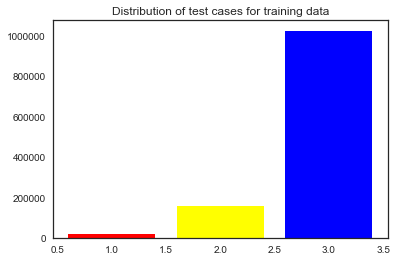

In [6]:
plt.bar(df_group_train.index, list(df_group_train["Accident_Index"]), color = ("red","yellow","blue"))
plt.title("Distribution of test cases for training data")

In [7]:
solution.columns.values

array(['Id', 'Accident_Severity'], dtype=object)

In [8]:
test.columns.values

array(['Id', 'Accident_Index', 'Location_Easting_OSGR',
       'Location_Northing_OSGR', 'Longitude', 'Latitude', 'Police_Force',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Date',
       'Day_of_Week', 'Time', 'Local_Authority_(District)',
       'Local_Authority_(Highway)', '1st_Road_Class', '1st_Road_Number',
       'Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control',
       '2nd_Road_Class', '2nd_Road_Number',
       'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area',
       'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location', 'Year'], dtype=object)

In [9]:
# join the test X variables and targe variable
test_with_solution = test.merge(solution, left_on='Id', right_on='Id', how='left')

In [10]:
test_with_solution.head()

,Id,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Number_of_Vehicles,Number_of_Casualties,Date,...,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Year,Accident_Severity
0,0,200501BS00001,525680.0,178240.0,-0.191170,51.489096,1,1,1,04/01/2005,...,Daylight: Street light present,Raining without high winds,Wet/Damp,None,None,1,Yes,E01002849,2005,2
1,1,200501BS00002,524170.0,181650.0,-0.211708,51.520075,1,1,1,05/01/2005,...,Darkness: Street lights present and lit,Fine without high winds,Dry,None,None,1,Yes,E01002909,2005,2
2,2,200501BS00007,524220.0,180830.0,-0.211277,51.512695,1,2,1,13/01/2005,...,Darkness: Street lights present and lit,Fine without high winds,Dry,None,None,1,Yes,E01002875,2005,3
3,3,200501BS00011,524550.0,180810.0,-0.206531,51.512443,1,2,5,15/01/2005,...,Daylight: Street light present,Fine without high winds,Dry,None,None,1,Yes,E01002875,2005,3
4,4,200501BS00012,526240.0,178900.0,-0.182872,51.494902,1,1,1,16/01/2005,...,Darkness: Street lights present and lit,Fine without high winds,Dry,None,None,1,Yes,E01002835,2005,3


Text(0.5,1,'Distribution of test cases for testing data')

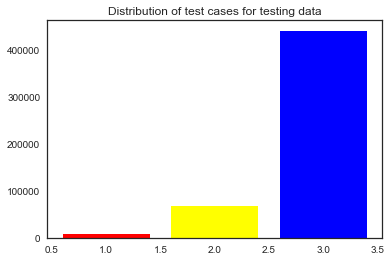

In [11]:
df_group_test = test_with_solution.groupby("Accident_Severity").count()
plt.bar(list(df_group_test.index), df_group_test["Accident_Index"], color = ("red","yellow","blue"))
plt.title("Distribution of test cases for testing data")

<div class="alert alert-block alert-info">
From the histogram, we can see the distribution is rather uneven which means we have a rather unbalanced dataset. Either undersample or oversample needs to be carried out to transform the training datasets.
</div>

# 2. Feature Engineering

In [12]:
# create a copy from the original data input
df_master = train
df_test = test_with_solution

## 2.1 Transforming Geographical Data

<div class="alert alert-block alert-info">
The geographical data which are latitude and longitude columns in the dataset are in a much larger scale compared to other variables. Thus, it is important to scale the inputs so as to eliminate the effects due to the scale difference. The distributions for before and after transformation are plotted as shown in the graphs below.

**Before Transformation:**

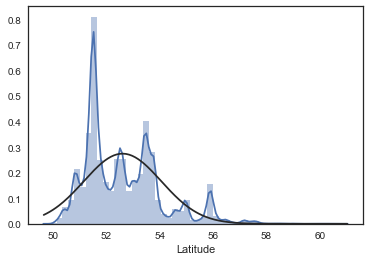

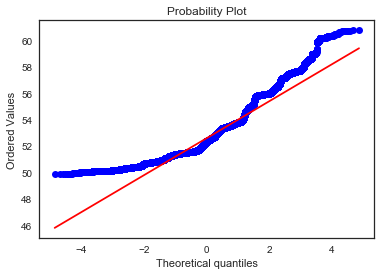

In [13]:
# visualise the previous distribution for latitude
df_pre = df_master[np.isfinite(train['Latitude'])]
df_pre = df_master[np.isfinite(train['Longitude'])]

sns.distplot(df_pre['Latitude'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_pre['Latitude'], plot=plt)
plt.show()

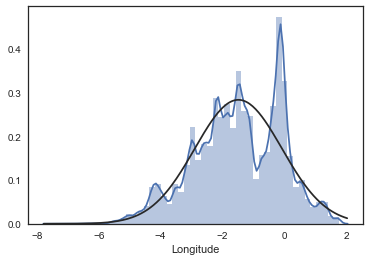

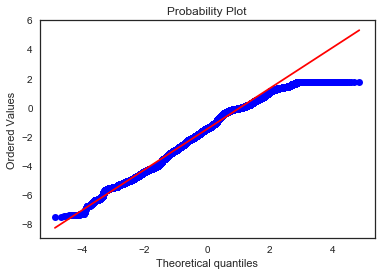

In [14]:
# visualise the previous distribution for longitude
sns.distplot(df_pre['Longitude'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_pre['Longitude'], plot=plt)
plt.show()

In [15]:
# drop the na rows in the dataframe
df_master = df_master[np.isfinite(df_master['Latitude'])]
df_master = df_master[np.isfinite(df_master['Longitude'])]
df_test = df_test[np.isfinite(df_test['Latitude'])]
df_test = df_test[np.isfinite(df_test['Longitude'])]

# Convert the latitude and longitude coordinates to area squares
latitude_min = min(train['Latitude'])
latitude_max = max(train['Latitude'])
longitude_min = min(train['Longitude'])
longitude_max = max(train['Longitude'])

# Determine the required step for a given number of areas
latitude_step = (latitude_max - latitude_min) / 1000
longitude_step = (longitude_max - longitude_min) / 1000

# Determine the latitude area
def calc_lat_area(current_lat):
    if math.isnan(current_lat):
        return -1
    
    return int(abs((current_lat - latitude_min)) / latitude_step)

# Determine the longitude area
def calc_lon_area(current_lon):
    if math.isnan(current_lon):
        return -1
    return int(abs((current_lon - longitude_min)) / longitude_step)

# Create new columns with the latitude and longitude areas
df_master["Latitude_Area"] = list(map(calc_lat_area, df_master["Latitude"]))
df_master["Longitude_Area"] = list(map(calc_lon_area, df_master["Longitude"]))

# standardise the feature
df_master['Latitude_Area'] = np.log1p(df_master['Latitude_Area']) 
df_master['Longitude_Area'] = np.log1p(df_master['Longitude_Area'])

df_test["Latitude_Area"] = list(map(calc_lat_area, df_test["Latitude"]))
df_test["Longitude_Area"] = list(map(calc_lon_area, df_test["Longitude"]))

# standardise the feature
df_test['Latitude_Area'] = np.log1p(df_test['Latitude_Area']) 
df_test['Longitude_Area'] = np.log1p(df_test['Longitude_Area'])

**After Transformation:**

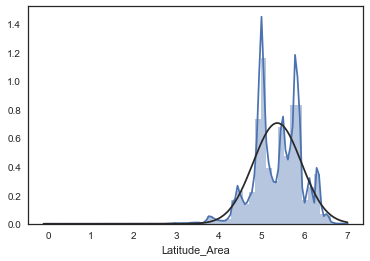

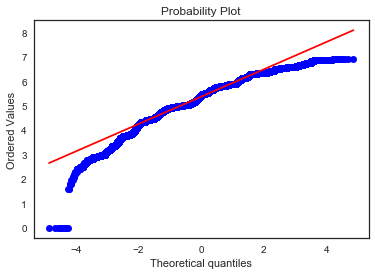

In [16]:
# viusalise latitude distribution after transformation
sns.distplot(df_master['Latitude_Area'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_master['Latitude_Area'], plot=plt)
plt.show()

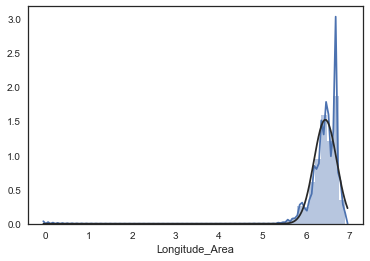

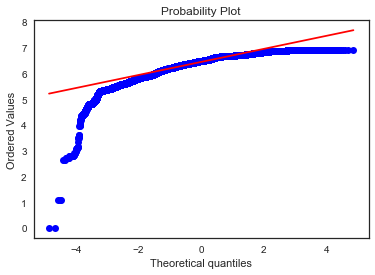

In [17]:
# viusalise longitude distribution after transformation
sns.distplot(df_master['Longitude_Area'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_master['Longitude_Area'], plot=plt)
plt.show()

<div class="alert alert-block alert-info">
From the plots, we can see the values now range in a much smaller values after transformation. This is especially true for latitude where it previously ranges from 50 to 60 has decreased to 1 to 8 after transformation. The values for geographical data after transformation is much more comparable with the rest of the attributes.
</div>

## 2.2 Adding Additional Time Features

<div class="alert alert-block alert-info">
Let's first take a look at the distribution of the time information we have:
</div>

In [18]:
# extract date time information
df_master ['Date'] = pd.to_datetime(df_master ['Date'], format= '%d/%m/%Y')
df_master ['Month'] = df_master ['Date'].dt.month
df_master ['Day_of_Month'] = df_master ['Date'].dt.day

df_master ['Time'] = pd.to_datetime( df_master ['Time'], format = '%H:%M')
df_master ['Hour'] = df_master ["Time"].dt.hour

df_test ['Date'] = pd.to_datetime(df_test['Date'], format= '%d/%m/%Y')
df_test ['Month'] = df_test['Date'].dt.month
df_test ['Day_of_Month'] = df_test['Date'].dt.day

df_test ['Time'] = pd.to_datetime(df_test['Time'], format = '%H:%M')
df_test ['Hour'] = df_test["Time"].dt.hour

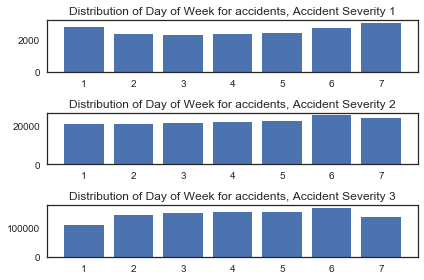

In [19]:
# plot the distribution across the week for different accident severity level
plt.subplot(3,1,1)
df_1 = df_master[df_master["Accident_Severity"] == 1]
df_week_1 = df_1.groupby("Day_of_Week").count()
plt.bar(list(df_week_1.index), df_week_1.iloc[:,1])
plt.title("Distribution of Day of Week for accidents, Accident Severity 1")

plt.subplot(3,1,2)
df_2 = df_master[df_master["Accident_Severity"] == 2]
df_week_2 = df_2.groupby("Day_of_Week").count()
plt.bar(list(df_week_2.index), df_week_2.iloc[:,1])
plt.title("Distribution of Day of Week for accidents, Accident Severity 2")

plt.subplot(3,1,3)
df_3 = df_master[df_master["Accident_Severity"] == 3]
df_week_3 = df_3.groupby("Day_of_Week").count()
plt.bar(list(df_week_3.index), df_week_3.iloc[:,1])
plt.title("Distribution of Day of Week for accidents, Accident Severity 3")

plt.tight_layout()

<div class="alert alert-block alert-info">
Firstly, we need to note that the total cases for 3 accident severity levels differ a lot. Thus, it is not meaninful to compare the absolute number. Instead, we should **compare the percentage of each group within each accident severity level**.
<br>
Based on the plot for **distribution of day of week across different accident severities**, we can see the percentage of accidents is generally higher during the weekdays for accident severity 2 and 3. While for accident severity 1, the accidents are more likely to happen during weekends. Thus, adding an attribute of "is_weekend" will be meaningful distinguish the accident severity type.
</div>

Text(0.5,1,'Distribution of Hour for accidents')

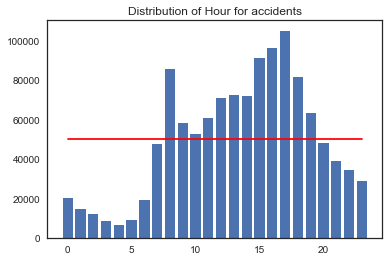

In [20]:
# plot the distribution of number of accidents across the day
df_time = df_master["Hour"].value_counts().sort_index()
plt.bar(list(df_time.index), list(df_time))

# add in an average line of the number accidents happening in different hours
hour_ave = np.average(list(df_time))
y_list = [hour_ave]* 24
plt.plot(list(df_time.index), y_list, c = 'red')
plt.title("Distribution of Hour for accidents")

<div class="alert alert-block alert-info">
Looking at the overall pictures, there are higher number of accidents happening during day time especially the morning peak hours and afternoon peak hours. (The red line represents the average number of accidents happening across 24 hours) We would like to know is the pattern different across different severity level.
</div>

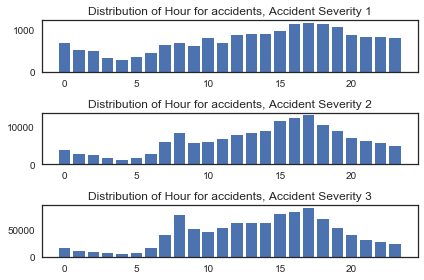

In [21]:
# plot the distribution of number of accidents across the day for different accident severity level
plt.subplot(3,1,1)
df_1 = df_master[df_master["Accident_Severity"] == 1]
df_hour_1 = df_1.groupby("Hour").count()
plt.bar(list(df_hour_1.index), df_hour_1.iloc[:,1])
plt.title("Distribution of Hour for accidents, Accident Severity 1")

plt.subplot(3,1,2)
df_2 = df_master[df_master["Accident_Severity"] == 2]
df_hour_2 = df_2.groupby("Hour").count()
plt.bar(list(df_hour_2.index), df_hour_2.iloc[:,1])
plt.title("Distribution of Hour for accidents, Accident Severity 2")

plt.subplot(3,1,3)
df_3 = df_master[df_master["Accident_Severity"] == 3]
df_hour_3 = df_3.groupby("Hour").count()
plt.bar(list(df_hour_3.index), df_hour_3.iloc[:,1])
plt.title("Distribution of Hour for accidents, Accident Severity 3")

plt.tight_layout()

<div class="alert alert-block alert-info">
Again, we will be comparing the percentage of the accident in a group for a particular severity level here. From the plot, we can see the distribution for accident severity 1 is more even across different time. While for accident severity 2 and 3, higher percentage of accidents happened during daytime. The difference in distribution suggests the addition of **'is_midnight' and 'is_peak_hour'** variables will be meaningful for for the prediction later.
</div>

<div class="alert alert-block alert-info">
Currently, the time information is very much in its raw format (e.g. data, time). We will based on the raw values and derive other attributes such as "is_peak_hour", "is_weekend", "is_midnight". Based on the plot and also the definition from official website.
<br>
**midnight: 8pm - 3am
<br>
peakhour: 7am - 9am; 5pm - 7pm**
</div>

In [22]:
def is_weekend(val):
    if math.isnan(val):
        return -1
    
    val = int(val)
    if val == 7 or val ==1:
        return 1
    else:
        return 0

# reference: https://www.londonpass.com/london-transport/london-underground-tips.html
# morning peak: 7:30 - 9:30
# afternoon peak: 17:00 - 19:00
def is_peak(val):
    if math.isnan(val):
        return -1
    
    val = int(val)
    if val in [7,8,9,17,18,19]:
        return 1
    else:
        return 0
    
def is_midnight(val):
    if math.isnan(val):
        return -1
    
    val = int(val)
    if val in [20,21,22,23,0,1,2,3]:
        return 1
    else:
        return 0

In [23]:
# addition of the new variables for both the training dataset and testing dataset
df_master["is_weekend"] = [is_weekend(i) for i in df_master["Day_of_Week"]]
df_master["is_peak"] = [is_peak(i) for i in df_master["Hour"]]
df_master["is_midnight"] = [is_midnight(i) for i in df_master["Hour"]]

df_test["is_weekend"] = [is_weekend(i) for i in df_test["Day_of_Week"]]
df_test["is_peak"] = [is_peak(i) for i in df_test["Hour"]]
df_test["is_midnight"] = [is_midnight(i) for i in df_test["Hour"]]

In [24]:
df_master.columns.values

array(['Accident_Index', 'Location_Easting_OSGR',
       'Location_Northing_OSGR', 'Longitude', 'Latitude', 'Police_Force',
       'Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties',
       'Date', 'Day_of_Week', 'Time', 'Local_Authority_(District)',
       'Local_Authority_(Highway)', '1st_Road_Class', '1st_Road_Number',
       'Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control',
       '2nd_Road_Class', '2nd_Road_Number',
       'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area',
       'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location', 'Year', 'Latitude_Area',
       'Longitude_Area', 'Month', 'Day_of_Month', 'Hour', 'is_weekend',
       'is_peak', 'is_midnight'], dtype=object)

In [25]:
df_master.head()

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,LSOA_of_Accident_Location,Year,Latitude_Area,Longitude_Area,Month,Day_of_Month,Hour,is_weekend,is_peak,is_midnight
0,200501BS00003,524520.0,182240.0,-0.206458,51.525301,1,3,2,1,2005-01-06,...,E01002857,2005,5.003946,6.670766,1,6,0.0,0,0,1
1,200501BS00004,526900.0,177530.0,-0.173862,51.482442,1,3,1,1,2005-01-07,...,E01002840,2005,4.976734,6.674561,1,7,10.0,0,0,0
2,200501BS00005,528060.0,179040.0,-0.156618,51.495752,1,3,1,1,2005-01-10,...,E01002863,2005,4.983607,6.677083,1,10,21.0,0,0,1
3,200501BS00006,524770.0,181160.0,-0.203238,51.515540,1,3,2,1,2005-01-11,...,E01002832,2005,4.997212,6.670766,1,11,12.0,0,0,0
4,200501BS00009,525890.0,179710.0,-0.187623,51.502260,1,3,1,2,2005-01-14,...,E01002889,2005,4.990433,6.673298,1,14,17.0,0,1,0


<div class="alert alert-block alert-info">
Before we move on to feature selection, we can remove some features based on the following reasons:
<br>
**1. The information is repeated in other column**
<br>
'Latitude_Area' and 'Longitude_Area' will be used as the geographical variables. Thus other columns that contains geographical information can be removed. This means columns including 'Location_Easting_OSGR', 'Location_Northing_OSGR','Longitude', 'Latitude','Local_Authority_(District)','Local_Authority_(Highway)','LSOA_of_Accident_Location'
<br>
**2. The values in the variable are largely skewed which means majority of the cases have the same value**
<br> 
As the distribution is largely skewed, it is thus not so meaningful to include the attribute as the attribute does no differentiate a particular severity level or value add to the prediction of different severity level. These columns include '2nd_Road_Class', '2nd_Road_Number','Pedestrian_Crossing-Human_Control','Pedestrian_Crossing-Physical_Facilities','Special_Conditions_at_Site', 'Carriageway_Hazards'.
<br>
**3. The values in the variable are largely NAs**
<br> 
NA means the information is not available, thus, it does not provide any information for prediction. Hence, it should be removed. These columns include Junction_Detail','Junction_Control'.
<br>
**4. Values that are distinct for each case**
<br> 
This refers to column 'Accident_Index' which is served as the primary key for the case and does not provide any information for the conditions when the accident happened.
<br>
<br>
Based on the above reasoning, the following variables are selected:
</div>

In [26]:
# selection of variables for training dataset
df_master = df_master[['Police_Force','Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties',
                       'Day_of_Week', '1st_Road_Class', 'Road_Type', 'Speed_limit', 
                       'Light_Conditions','Weather_Conditions', 'Road_Surface_Conditions','Urban_or_Rural_Area',
                       'Did_Police_Officer_Attend_Scene_of_Accident','Latitude_Area',
                       'Longitude_Area', 'Month', 'Day_of_Month', 'Hour', 'is_weekend', 'is_peak','is_midnight']]

In [27]:
# selection of variables for testing dataset
df_test = df_test[['Police_Force','Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties',
                       'Day_of_Week', '1st_Road_Class', 'Road_Type', 'Speed_limit', 
                       'Light_Conditions','Weather_Conditions', 'Road_Surface_Conditions','Urban_or_Rural_Area',
                       'Did_Police_Officer_Attend_Scene_of_Accident','Latitude_Area',
                       'Longitude_Area', 'Month', 'Day_of_Month', 'Hour', 'is_weekend', 'is_peak','is_midnight']]

## 2.3 Transform to Numeric Categorical Values

<div class="alert alert-block alert-info">
As most of the variable inputs are in string, we will need to transform that to numeric categorical values for easy manipulations later.
</div>

In [28]:
# change the value for Light_Conditions
light_dic = {'Darkeness: No street lighting': 4,
            'Darkness: Street lighting unknown': 5,
            'Darkness: Street lights present and lit': 2,
            'Darkness: Street lights present but unlit': 3,
            'Daylight: Street light present': 1}
df_master = df_master.replace({"Light_Conditions": light_dic})
df_test = df_test.replace({"Light_Conditions": light_dic})

In [29]:
# change the value for Weather_Conditions
weather_dic = {'Fine with high winds': 1,
               'Fine without high winds': 2,
               'Fog or mist': 3,
               'Other': 4,
               'Raining with high winds': 6,
               'Raining without high winds': 5,
               'Snowing with high winds': 8,
               'Snowing without high winds': 7,
               'Unknown': -1}
df_master = df_master.replace({"Weather_Conditions": weather_dic})
df_test = df_test.replace({"Weather_Conditions": weather_dic})

In [30]:
# change the value for Road_Surface_Conditions
road_dic = {'Dry': 1,
            'Flood (Over 3cm of water)': 5,
            'Frost/Ice': 4, 
            'Snow': 3, 
            'Wet/Damp': 2}
df_master = df_master.replace({"Road_Surface_Conditions": road_dic})
df_test = df_test.replace({"Road_Surface_Conditions": road_dic})

In [31]:
road_type_dic = {'Roundabout':1,
                 'One way street':2,
                 'Dual carriageway':3,
                 'Single carriageway':4,
                 'Slip road':5,
                 'Unknown':-1}
df_master = df_master.replace({'Road_Type': road_type_dic})
df_test = df_test.replace({'Road_Type': road_type_dic})

In [32]:
police_dic = {'Yes':1,'No':2,'nan':-1}
df_master = df_master.replace({'Did_Police_Officer_Attend_Scene_of_Accident':police_dic})
df_test = df_test.replace({'Did_Police_Officer_Attend_Scene_of_Accident':police_dic})

In [33]:
df_master.head()

,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,1st_Road_Class,Road_Type,Speed_limit,Light_Conditions,Weather_Conditions,...,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,Latitude_Area,Longitude_Area,Month,Day_of_Month,Hour,is_weekend,is_peak,is_midnight
0,1,3,2,1,5,5,4,30,2,2.0,...,1,1.0,5.003946,6.670766,1,6,0.0,0,0,1
1,1,3,1,1,6,3,4,30,1,2.0,...,1,1.0,4.976734,6.674561,1,7,10.0,0,0,0
2,1,3,1,1,2,6,4,30,5,2.0,...,1,1.0,4.983607,6.677083,1,10,21.0,0,0,1
3,1,3,2,1,3,6,4,30,1,5.0,...,1,1.0,4.997212,6.670766,1,11,12.0,0,0,0
4,1,3,1,2,6,3,3,30,1,2.0,...,1,1.0,4.990433,6.673298,1,14,17.0,0,1,0


In [34]:
df_master.columns.values

array(['Police_Force', 'Accident_Severity', 'Number_of_Vehicles',
       'Number_of_Casualties', 'Day_of_Week', '1st_Road_Class',
       'Road_Type', 'Speed_limit', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Urban_or_Rural_Area',
       'Did_Police_Officer_Attend_Scene_of_Accident', 'Latitude_Area',
       'Longitude_Area', 'Month', 'Day_of_Month', 'Hour', 'is_weekend',
       'is_peak', 'is_midnight'], dtype=object)

## 2.4 Adjusting the Scale for Speed Limit

<div class="alert alert-block alert-info">
As most of the variable inputs are within 1-10 range, while for speed limit, the range is goes up to 80. Thus, we will need to adjust the scale for speed limit and ensure it is alined with other input variables.
</div>

In [35]:
# adjust the scale foe speed limit by dividing by 10
df_master['Speed_limit'] = df_master['Speed_limit']/10
df_test['Speed_limit'] = df_test['Speed_limit']/10

In [36]:
df_master.replace(-1, np.nan, inplace=True)
df_master = df_master.dropna()

df_test.replace(-1, np.nan, inplace=True)
df_test = df_test.dropna()

In [37]:
print ('After dropping NAs', len(df_master))

After dropping NAs 1160419


In [38]:
print ('Before dropping NAs', len(train))

Before dropping NAs 1196390


# 3. Feature Selection

## Correlation

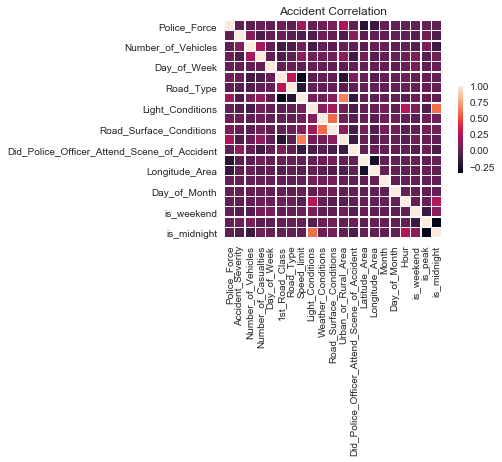

In [39]:
# Compute the correlation matrix
corr_master = df_master.corr(method='kendall')

# Draw the correlation matrix
sns.heatmap(corr_master, square=True, linewidths=.4, cbar_kws={"shrink": .4})

plt.title("Accident Correlation")
plt.show()

<div class="alert alert-block alert-info">
There are variables that are correlated, such as road_surface_conditions and weather_conditions. However, it is unsure which one of these correlated variables to remove. Thus, we will use the recursive feature elimination in the later section to decide the variables to remove.
</div>

In [40]:
# zoom in to accident severity column to have a closer look
corr_master = corr_master.abs()
corr_master['Accident_Severity'].sort_values()

Day_of_Week                                    0.001278
Day_of_Month                                   0.002042
Month                                          0.003959
Longitude_Area                                 0.004141
Police_Force                                   0.007732
Road_Surface_Conditions                        0.009571
1st_Road_Class                                 0.013920
Hour                                           0.015186
Latitude_Area                                  0.021912
Weather_Conditions                             0.025401
is_peak                                        0.029503
Road_Type                                      0.036658
is_weekend                                     0.040189
Speed_limit                                    0.063809
Light_Conditions                               0.065630
is_midnight                                    0.068017
Urban_or_Rural_Area                            0.072364
Number_of_Casualties                           0

<div class="alert alert-block alert-info">
We will drop the last two ranked attributes as they are not siginificant and contained in other attributes
</div>

In [41]:
df_master = df_master.drop(['Day_of_Week', 'Day_of_Month'], axis = 1).reset_index()
df_test = df_test.drop(['Day_of_Week', 'Day_of_Month'], axis = 1).reset_index()

# 4. Sampling the Dataset

<div class="alert alert-block alert-info">
Based on the plots shown in section 1, the distribution of target variable(accident severity) is extremely uneven. Thus, it is important to re-sample the data to adjust the distribution in the training dataset. There are a few ways to adjust the distribution such as undersample and oversample. However, as the size of the training dataset is rather big and goes beyong the computing power of our laptops, we have limited the size of the training dataset and sampled based on the counts for severity level 2.
</div>

In [42]:
def undersample(df):
    count_class_3, count_class_2, count_class_1 = df.Accident_Severity.value_counts()
    
    # split based on accident severity
    df_class_1 = df[df['Accident_Severity'] == 1]
    df_class_2 = df[df['Accident_Severity'] == 2]
    df_class_3 = df[df['Accident_Severity'] == 3]
    
    # Random under-sampling
    df_class_3_under = df_class_3.sample(count_class_1)
    df_class_2_under = df_class_2.sample(count_class_1)

    df_train_under = pd.concat([df_class_3_under, df_class_1],axis=0)
    df_train_under = pd.concat([df_train_under, df_class_2_under], axis = 0)
    
    return df_train_under
    

In [43]:
def oversample(df):
    count_class_3, count_class_2, count_class_1 = df.Accident_Severity.value_counts()
    
    # split based on accident severity
    df_class_1 = df[df['Accident_Severity'] == 1]
    df_class_2 = df[df['Accident_Severity'] == 2]
    df_class_3 = df[df['Accident_Severity'] == 3]
    
    # Random over-sampling
    df_class_1_over = df_class_1.sample(count_class_3, replace = True)
    df_class_2_over = df_class_2.sample(count_class_3, replace = True)

    df_train_over = pd.concat([df_class_3, df_class_1_over], axis = 0)
    df_train_over = pd.concat([df_train_over, df_class_2_over], axis = 0)

    return df_train_over

In [44]:
def midsample(df):
    count_class_3, count_class_2, count_class_1 = df.Accident_Severity.value_counts()
    
    # split based on accident severity
    df_class_1 = df[df['Accident_Severity'] == 1]
    df_class_2 = df[df['Accident_Severity'] == 2]
    df_class_3 = df[df['Accident_Severity'] == 3]
    
    # Random over-sampling for class 1 and class 2
    df_class_1_over = df_class_1.sample(count_class_2, replace = True)
    # df_class_2_over = df_class_2.sample(500000, replace = True)
    # Random under-sampling for class 3
    df_class_3_under = df_class_3.sample(count_class_2)
    
    df_train_mid = pd.concat([df_class_2, df_class_1_over], axis = 0)
    df_train_mid = pd.concat([df_train_mid, df_class_3_under], axis = 0)

    return df_train_mid

In [45]:
df_train_under = undersample(df_master)

In [46]:
print ("Random under-sampling:")
print (df_train_under.Accident_Severity.value_counts())

Random under-sampling:
3    17574
2    17574
1    17574
Name: Accident_Severity, dtype: int64


In [47]:
df_train_mid = midsample(df_master)

In [48]:
print ("Random mid-sampling:")
print (df_train_mid.Accident_Severity.value_counts())

Random mid-sampling:
3    152979
2    152979
1    152979
Name: Accident_Severity, dtype: int64


In [49]:
df_train_over = oversample(df_master)

In [50]:
print ("Random over-sampling:")
print (df_train_over.Accident_Severity.value_counts())

Random over-sampling:
3    989866
2    989866
1    989866
Name: Accident_Severity, dtype: int64


In [51]:
# training dataset
X_under = df_train_under.drop(["Accident_Severity"], axis = 1)
Y_under = df_train_under[['Accident_Severity']]

X_mid = df_train_mid.drop(["Accident_Severity"], axis = 1)
Y_mid = df_train_mid[['Accident_Severity']]

X_over = df_train_over.drop(["Accident_Severity"], axis = 1)
Y_over = df_train_over[['Accident_Severity']]

In [52]:
# testing dataset
X_test = df_test.drop(["Accident_Severity"], axis = 1)
Y_test = df_test[['Accident_Severity']]

# 5. One Hot Encoding

<div class="alert alert-block alert-info">
One hot encoding is used here to transform the categorical variable to multiple binary columns. We understand by transforming this way, it will increase the nummber of features dramatically. Thus, the dataset retrieved after one hot encoding will be handled with PCA to reduce the dimension and then feed into prediction model. We would like to compare the performance of dataset transformed using one hot encoding with the one without transformation.

In [53]:
# function takes in the dataframe and the columns need to be transformed in the dataframe
def onehotencoding(df, col_list):
    df_totransform = df[col_list]
    
    df.drop(col_list, axis = 1)
    
    ohe = OneHotEncoder(sparse=False)
    array_ohe = ohe.fit_transform(df_totransform)
    df_categorical_ohe = pd.DataFrame(array_ohe)
    
    df_categorical_ohe = df_categorical_ohe.reset_index()
    df_noncategorical = df.reset_index()
    df_ohe = pd.concat([df_categorical_ohe, df_noncategorical], axis=1)
    
    return df_ohe

In [54]:
to_be_transformed = ['Police_Force','Speed_limit', '1st_Road_Class', 'Road_Type', 
                     'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 
                     'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident']

In [55]:
# the transformed dataset for 3 sampled dataframe
X_under_encoded = onehotencoding(X_under, to_be_transformed).drop(['index'], axis =1)

X_mid_encoded = onehotencoding(X_mid, to_be_transformed).drop(['index'], axis =1)

X_over_encoded = onehotencoding(X_over, to_be_transformed).drop(['index'], axis =1)

In [56]:
X_mid = X_mid.drop(['index'],axis = 1)
X_test = X_test.drop(['index'],axis = 1)

# 6. Prediciton Model Training

## 6.1 Model Selection

In [57]:
# general prediction function that takes in the model used, training and testing dataset
# the output for the function will be the F1 score of the model
def model_pred(model, X_train, Y_train, X_test, Y_test):
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    
    result = f1_score(Y_test, Y_pred, average = 'micro')
    
    return result

In [58]:
# Random Forest
rf = RandomForestClassifier()
rf_result = model_pred(rf, X_mid, Y_mid, X_test, Y_test)

print ("The F1 score for random forest is, ", rf_result)

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


The F1 score for random forest is,  0.5855523152543257


In [59]:
# Logistic Regression
lr = LogisticRegression()
lr_result = model_pred(lr, X_mid, Y_mid, X_test, Y_test)

print ("The F1 score for logistic regression is, ", lr_result)


/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The F1 score for logistic regression is,  0.45332460927386253


In [60]:
# Decision Trees
dt = DecisionTreeClassifier()
dt_result = model_pred(dt, X_mid, Y_mid, X_test, Y_test)

print ("The F1 score for decision tree is, ", dt_result)

The F1 score for decision tree is,  0.5867324717655583


<div class="alert alert-block alert-info">
We have tested with 3 classfication models above (random forest, logistic regression and decision tree). Random forest and decision tree appears to be a more suitable prediction model for this case. Thus, for the further optimization of paramters and hyperparameter tuning will be based on random forest model.
</div>

## 6.2 Dimensionality Reduction - PCA

<div class="alert alert-block alert-info">
Dimensionality reduction is used to for the one hot encoded dataset.
</div>

In [61]:
pca_mid = PCA()
fit = pca_mid.fit(X_mid_encoded)

In [62]:
total = 0
num_of_components = 0
for ratio in pca_mid.explained_variance_ratio_:
    if total < 0.88:
        print(ratio)
        total += ratio
        num_of_components += 1
    else:
        break
print("We need %d components to explain at least %.2f percent of the data." %(num_of_components, total*100))

0.9999999934361936
We need 1 components to explain at least 100.00 percent of the data.


In [63]:
# Projecting our n dimension data onto 1 dimension space
pca_mid2 = PCA(n_components=1)
X_mid_pca = pca_mid2.fit_transform(X_mid)

X_mid_pca.shape 

(458937, 1)

In [64]:
X_mid_pca_test = pca_mid2.fit_transform(X_test)

In [65]:
new_X_mid = pd.DataFrame(data=X_mid_pca)
new_X_mid.columns = ['PC'+str(i) for i in range(1, 2)]

rf = RandomForestClassifier()
rf.fit(new_X_mid, Y_mid)
Y_pred = rf.predict(X_mid_pca_test)
result = f1_score(Y_test, Y_pred, average = 'micro')

print ('The F1 score after PCA dimensionality reduction is: ', result)

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


The F1 score after PCA dimensionality reduction is:  0.4440559651091143


<div class="alert alert-block alert-info">
As shown in result for F1 score, it appears that using one hot encoding and PCA dimensionality reduction does not help to improve the performance of the model. Thus, instead of using one hot encoding and PCA, we will keep the numeric categorical variables and tap on recursive feature elimination to improve the model performance.
</div>

## 6.3 Recursive Feature Elimination

<div class="alert alert-block alert-info">
Recursive feature elimination will select top n number of features that give the model the best performance. As there are 18 features in the model, we thus loop through 1 to 18 and assess when will the best F1 score be achieved.
</div>

In [66]:
# input:
# model - the model used for this run
# n - number of features should be selected
# output:
# the F1 score for this particular model with n features
def rfe_selection(model, n, X_train, X_test, Y_train, Y_test):
    # fitting the model to RFE 
    rfe = RFE(model, n)
    fit= rfe.fit(X_train, Y_train)
    
    # transform the x inputs based on feature selection
    X_train_transformed = rfe.fit_transform(X_train, Y_train)
    X_test_transformed = rfe.fit_transform(X_test, Y_test)
    
    model.fit(X_train_transformed, Y_train)
    Y_pred = model.predict(X_test_transformed)
    result = f1_score(Y_test, Y_pred, average = 'micro')
    ranks = fit.ranking_
    
    return [ranks, result]

In [69]:
# input:
# model - the model used for this run
# X_train, X_test: the transformed X_training and testing dataset from the result of recursive feature elimination
# Output: the F1 score for the current run
def selection_df(model, m, X_train, X_test, Y_train, Y_test):
    columns = list(range(2))
    index = list(range(m+1)[1:])
    df = pd.DataFrame(columns = columns, index = index)
    df = df.fillna("NA")
    
    for i in range(1, m+1):
        rank, result = rfe_selection(model, i, X_train, X_test, Y_train, Y_test)
    
        df.iloc[i-1,0] = rank
        df.iloc[i-1,1] = result
    
    return df

In [70]:
rf = RandomForestClassifier()
df_rf = selection_df(rf, 18, X_mid, X_test, Y_mid, Y_test)

/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel(

/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel(

/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel(

In [71]:
df_rf

,0,1
1,"[6, 7, 8, 5, 14, 9, 13, 10, 11, 17, 15, 2, 1, ...",0.323827
2,"[5, 4, 8, 6, 12, 7, 13, 9, 10, 16, 14, 1, 1, 3...",0.466623
3,"[4, 3, 6, 5, 11, 7, 10, 8, 9, 13, 12, 1, 1, 2,...",0.541638
4,"[4, 2, 5, 3, 8, 6, 10, 7, 9, 14, 11, 1, 1, 1, ...",0.564677
5,"[5, 2, 4, 1, 9, 3, 8, 6, 7, 13, 11, 1, 1, 1, 1...",0.469457
6,"[1, 2, 4, 1, 9, 3, 7, 5, 6, 11, 8, 1, 1, 1, 1,...",0.555623
7,"[1, 1, 2, 1, 5, 3, 7, 4, 6, 8, 11, 1, 1, 1, 1,...",0.630852
8,"[1, 1, 2, 1, 5, 1, 6, 3, 4, 10, 8, 1, 1, 1, 1,...",0.575378
9,"[1, 1, 1, 1, 6, 1, 4, 2, 5, 8, 7, 1, 1, 1, 1, ...",0.578923
10,"[1, 1, 1, 1, 4, 1, 3, 2, 1, 7, 6, 1, 1, 1, 1, ...",0.61342


In [79]:
max_row = np.argmax(df_rf.iloc[:,1].values) + 1

In [80]:
rf = RandomForestClassifier()
# max_row = np.argmax(df_rf.iloc[:,1].values) + 1
max_row = 15
print ('The optimal number of parameters chosen is ', max_row)

# fitting the model to RFE 
rfe = RFE(rf, max_row)
fit= rfe.fit(X_mid, Y_mid)
    
# transform the x inputs based on feature selection
X_train_transformed = rfe.fit_transform(X_mid, Y_mid)
X_test_transformed = rfe.fit_transform(X_test, Y_test)
    
rf.fit(X_train_transformed, Y_mid)
Y_pred = rf.predict(X_test_transformed)
result = f1_score(Y_test, Y_pred, average = 'micro')

The optimal number of parameters chosen is  15


/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel(

<div class="alert alert-block alert-info">
From the result, the best performing model is achieved when the top 11 features are selected and the F1 score is as following:
</div>

In [81]:
print (result)

0.5869291645174304


## 6.4 Hyperparameter Tuning

<div class="alert alert-block alert-info">
In this section, with the refined training dataset, we will then move on to finetune the hyperparameters in the model. We will use grid search with a range of variables to be selected for each hyperparamter and locate the most optimal combination for the hyperparamter that gives the best perfomring prediction model.
</div>

In [82]:
# getting the current parameters
rf.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [83]:
# implement grid search using sklearn library
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [4, 5],
    'min_samples_leaf': [5, 10, 15],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}
# Create a based model
random_f = RandomForestClassifier()
# Instantiate the grid search model
grid_search = RandomizedSearchCV(estimator = random_f, param_distributions = param_grid, 
                          scoring = 'f1_micro', cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train_transformed, Y_mid)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] min_samples_split=12, max_features=5, bootstrap=True, max_depth=100, min_samples_leaf=5, n_estimators=300 
[CV] min_samples_split=12, max_features=5, bootstrap=True, max_depth=100, min_samples_leaf=5, n_estimators=300 
[CV] min_samples_split=12, max_features=5, bootstrap=True, max_depth=100, min_samples_leaf=5, n_estimators=300 
[CV] min_samples_split=10, max_features=4, bootstrap=True, max_depth=80, min_samples_leaf=5, n_estimators=300 


/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

KeyboardInterrupt: 

In [ ]:
grid_search.cv_results_

In [ ]:
grid_search.best_score_

In [ ]:
# the parameters that give the best performing model
grid_search.best_params_

# 7. Final Model

In [ ]:
def choose_column(df, chosen):
    cols = list(df.columns.values)
    chosen_cols = []
    
    for i in range(0, len(chosen)):
        if chosen[i] == 1:
            chosen_cols.append(cols[i])
        
    return chosen_cols

In [ ]:
# the parameter used here is the ones found in the previous section
rf_optimised = RandomForestClassifier(bootstrap=True, max_depth=100, max_features=5,
                                      min_samples_leaf=5, min_samples_split=10, n_estimators=300)

rf_optimised.fit(X_train_transformed, Y_mid)
Y_pred = rf_optimised.predict(X_test_transformed)
result = f1_score(Y_test, Y_pred, average = 'micro')

In [ ]:
# assess the model with F1 score
print ('The optimised F1 score is: ', result)

In [ ]:
# assess the model by looking at the confusion matrix
confusion_matrix(Y_test, Y_pred)

In [ ]:
import seaborn as sn
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), index = [i for i in "123"],
                     columns = [i for i in "123"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# Conclusion

<div class="alert alert-block alert-info">
From the result derived in the previous section, we obtain a quite satisfying F1 score which is 80. However, if we drill down further and look at the confusion matrix for the prediction, we realise the accuracy of prediction for severity level 1 and 2 is rather low. There are quite a number of false positive in the prediction result. 
<br>
<br>
There are a few reasons that might affect the performance for the model. Firstly, this may be due to the uneven distribution for each severity level. For severity level 1, the test cases are much smaller compared to other severity levels, this will affect the classification model to learn the pattern when predicting for severity level 1 cases. In order to improve the model, we can have more data entries for severity 1. Besides, we realise all the features in the dataset shows low correlation with the target variable, accident severity. We might need to include other features such as the characteristics about drivers that show higher correlation with the target variable to improve the model performance. 
<br>
<br>
Once a more accurate prediction model is found, this model can help police force to prioritise their assistance when multiple accidents happened at the same time. More police force can be supplied to cases that are predicted to be more severe. This will serve as a mean to lower the impact for the accidents.